In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:8787/status,
Dashboard: http://137.129.155.67:8787/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/49006/1,Workers: 1
Dashboard: http://137.129.155.67:8787/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/49006/4,Total threads: 4
Dashboard: http://137.129.155.67:44081/status,Memory: 78.61 GiB
Nanny: None,


In [17]:
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/'
filenames = np.arange(2009,2010)

datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_anom + 'OLR/anom_OLR_brut_ERA5_3H_'+str(f)+'.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom_OLR = xr.concat(datasets, dim='time', coords='minimal', compat='override')

datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_anom + 'TCWV/anom_tcwv_brut_ERA5_3H_'+str(f)+'.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom_TCWV = xr.concat(datasets, dim='time', coords='minimal', compat='override')
ds_anom_TCWV


<xarray.Dataset>
Dimensions:    (latitude: 321, longitude: 1440, time: 2920)
Coordinates:
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... -39.5 -39.75 -40.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2009-01-01 ... 2009-12-31T21:00:00
Data variables:
    tcwv_ano   (time, latitude, longitude) float64 dask.array<chunksize=(150, 321, 1440), meta=np.ndarray>

In [3]:
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=0.0, 
                         max_latitude=15.0,
                         globe=None)


In [28]:
_ds_anom_OLR = ds_anom_OLR.assign_coords(lon=(((ds_anom.lon + 180) % 360) - 180)).sortby('lon')
_ds_anom_OLR = _ds_anom_OLR.sel(time= '2009-09-01T12', lon = slice(-15,20))

_ds_anom_TCWV = ds_anom_TCWV.assign_coords(longitude=(((ds_anom_TCWV.longitude + 180) % 360) - 180)).sortby('longitude')
_ds_anom_TCWV = _ds_anom_TCWV.sel(time= '2009-09-01T12', longitude = slice(-15,20))
_ds_anom_TCWV

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:    (latitude: 321, longitude: 141)
Coordinates:
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... -39.5 -39.75 -40.0
  * longitude  (longitude) float32 -15.0 -14.75 -14.5 -14.25 ... 19.5 19.75 20.0
    time       datetime64[ns] 2009-09-01T12:00:00
Data variables:
    tcwv_ano   (latitude, longitude) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>

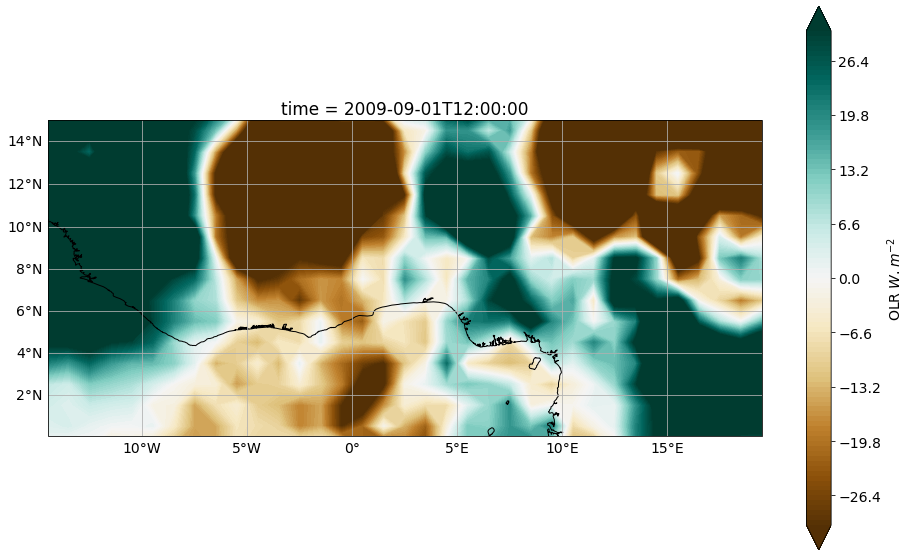

In [15]:
plt.rc("figure", figsize=(16,10))
cmap ='BrBG'
vmin, vmax = -30, +30

#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

_ds_anom['OLR_ano'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

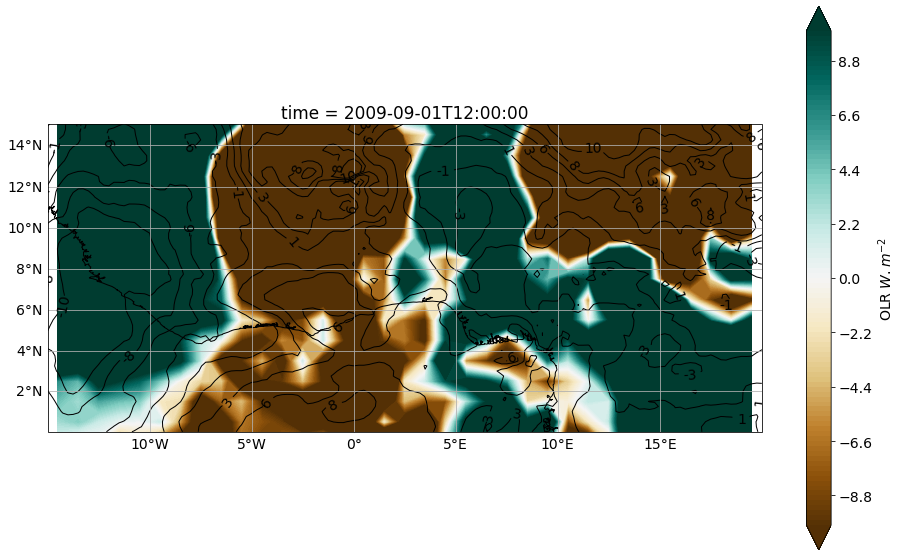

In [40]:
plt.rc("figure", figsize=(16,10))
cmap ='BrBG'
vmin, vmax = -10, +10

#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

_ds_anom['OLR_ano'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)

cs = _ds_anom_TCWV['tcwv_ano'].plot.contour(ax=axis, levels = 10, vmin = vmin, vmax = vmax, linewidths = 1,
                    transform=ccrs.PlateCarree(),
                    cmap='black')

axis.coastlines()
axis.clabel(cs, fmt='%1.0f')

gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()